# BERT Turkish Text Classification

## Helper Functions

In [26]:
%load_ext autoreload
%autoreload 2

from utils import *

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
import pickle
from tqdm.notebook import tqdm

from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz



def create_model_output_function(model):
    
    def model_output(inputs):
        return model(inputs)[0]
        
    return model_output



def construct_input_and_baseline(text, tokenizer):

    max_length = 510
    baseline_token_id = tokenizer.pad_token_id 
    sep_token_id = tokenizer.sep_token_id 
    cls_token_id = tokenizer.cls_token_id 

    text_ids = tokenizer.encode(text, max_length=max_length, truncation=True, add_special_tokens=False)
   
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = tokenizer.convert_ids_to_tokens(input_ids)
  
    baseline_input_ids = [cls_token_id] + [baseline_token_id] * len(text_ids) + [sep_token_id]

    # Trim tokens to remove ## symbols
    trimmed_tokens = [token if not token.startswith("##") else token[2:] for token in token_list]

    return torch.tensor([input_ids], device=device), torch.tensor([baseline_input_ids], device=device), trimmed_tokens



def interpret_text(text, lig, model, tokenizer, true_class):
    
    input_ids, baseline_input_ids, tokens = construct_input_and_baseline(text, tokenizer)
    attributions, delta = lig.attribute(inputs=input_ids,
                                        baselines=baseline_input_ids,
                                        return_convergence_delta=True,
                                        target=true_class)

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions_sum = attributions / torch.norm(attributions)

    # Get token-level attributions and their corresponding weights
    token_attributions = [(token, attr.item()) for token, attr in zip(tokens, attributions_sum)]

    score_vis = viz.VisualizationDataRecord(
        word_attributions=attributions_sum,
        pred_prob=torch.max(model(input_ids)[0]),
        pred_class=torch.argmax(model(input_ids)[0]).cpu().numpy(),
        true_class=true_class,
        attr_class=text,
        attr_score=attributions_sum.sum(),
        raw_input_ids=tokens,
        convergence_score=delta
    )

    return token_attributions, score_vis



def apply_ig(files_path, samples, lig, model, tokenizer, file_name, only_load=True):

    if only_load:
        ig_values, visualizations = pickle.load(open(files_path + f"{file_name}.pkl", 'rb'))
        
    else:
        ig_values = []
        visualizations = []
        
        with torch.no_grad():
            
            for sample in tqdm(samples):
            
                token_attributions, score_vis = interpret_text(sample['text'], lig, model, tokenizer, int(sample['label']))
                token_attributions_df = pd.DataFrame(token_attributions, columns=['Token', str(score_vis.pred_class)])

                token_attributions_df = token_attributions_df.sort_values(by=str(score_vis.pred_class), ascending=False)
                
                ig_values.append(token_attributions_df)
                visualizations.append(score_vis)
        
                del token_attributions
                del token_attributions_df
        
        pickle.dump((ig_values, visualizations), open(files_path + f"{file_name}.pkl", 'wb'))
        print(f"File '{file_name}' saved.")
    
    print(f"Loaded '{file_name}' file length:", len(ig_values))

    return ig_values, visualizations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

## Parameters

In [2]:
import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')

path_config = "config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_model_ttc4900 = config["path_model_ttc4900"]
path_model_tr_news = config["path_model_tr_news"] 
path_model_interpress = config["path_model_interpress"]
path_model_tc32 = config["path_model_tc32"]

path_ig = config["path_ig"]
threshold = config["threshold"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_model_ttc4900,Models/bert_text_classification_fine_tuned_ttc4900
5,path_model_tr_news,Models/bert_text_classification_fine_tuned_tr_news
6,path_model_interpress,Models/bert_text_classification_fine_tuned_interpress
7,path_model_tc32,Models/bert_text_classification_fine_tuned_tc32
8,path_shap,Data/SHAP/
9,path_ig,Data/IG/


## Load Models

In [3]:
from load_models import prepare_models

model_ttc4900, tokenizer_ttc4900, config_ttc4900, pipeline_text_ttc4900, label2id_ttc4900, id2label_ttc4900 = prepare_models(path_model_ttc4900, device)
model_tr_news, tokenizer_tr_news, config_tr_news, pipeline_text_tr_news, label2id_tr_news, id2label_tr_news = prepare_models(path_model_tr_news, device)
model_interpress, tokenizer_interpress, config_interpress, pipeline_text_interpress, label2id_interpress, id2label_interpress = prepare_models(path_model_interpress, device)
model_tc32, tokenizer_tc32, config_tc32, pipeline_text_tc32, label2id_tc32, id2label_tc32 = prepare_models(path_model_tc32, device)

Error caught was: No module named 'triton'



Loaded model 'bert_text_classification_fine_tuned_ttc4900' has following classes:

0: siyaset
1: dunya
2: ekonomi
3: kultur
4: saglik
5: spor
6: teknoloji

Loaded model 'bert_text_classification_fine_tuned_tr_news' has following classes:

0: türkiye
1: dünya
2: spor
3: ekonomi
4: sağlık
5: yaşam
6: gündem
7: sanat
8: teknoloji
9: eğitim
10: siyaset

Loaded model 'bert_text_classification_fine_tuned_interpress' has following classes:

0: kültürsanat
1: ekonomi
2: siyaset
3: eğitim
4: dünya
5: spor
6: teknoloji
7: magazin
8: sağlık
9: gündem

Loaded model 'bert_text_classification_fine_tuned_tc32' has following classes:

0: kamu-hizmetleri
1: finans
2: cep-telefon-kategori
3: enerji
4: ulasim
5: kargo-nakliyat
6: medya
7: mutfak-arac-gerec
8: alisveris
9: mekan-ve-eglence
10: elektronik
11: beyaz-esya
12: kucuk-ev-aletleri
13: internet
14: giyim
15: etkinlik-ve-organizasyon
16: icecek
17: saglik
18: sigortacilik
19: spor
20: mobilya-ev-tekstili
21: otomotiv
22: turizm
23: egitim
24: gid

In [4]:
# get_model_details(config, tokenizer)

In [5]:
# print(model)

In [6]:
# text = "Yapay Zeka Destekli Sağlık Teknolojisi, Tedavi Süreçlerini Dönüştürüyor. Teknoloji alanında yapılan yeni bir gelişme, yapay zeka destekli sağlık teknolojilerinde devrim niteliğinde ilerlemelere işaret ediyor. Yapılan son araştırmalarla birlikte, sağlık sektöründe kullanılan yapay zeka algoritmalarıyla hastaların tedavi süreçleri daha etkili bir şekilde yönetilebilir hale geliyor."

# prediction_results = predict(text, model_tr_news, tokenizer_tr_news, top_k=None, device=device, mode='custom', id2label=id2label_tr_news)
# prediction_results

## Load Datasets

In [7]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32, max_length=512)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Inference on Full Text

In [8]:
# predict_parameter_set_ttc4900 = {
#     'model': model_ttc4900,
#     'tokenizer': tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': model_tr_news,
#     'tokenizer': tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': model_interpress,
#     'tokenizer': tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': model_tc32,
#     'tokenizer': tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, label2id_tc32)

# path_classification_results = "Data/Classification_Results/"

# with open(path_classification_results + 'full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(full_text_preds_ttc4900, file)

# with open(path_classification_results + 'full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(full_text_preds_tr_news, file)

# with open(path_classification_results + 'full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(full_text_preds_interpress, file)

# with open(path_classification_results + 'full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(full_text_preds_tc32, file)

In [36]:
path_classification_results = "Data/Classification_Results/"

with open(path_classification_results + 'full_text_preds_ttc4900.pkl', 'rb') as file:
    full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'full_text_preds_tr_news.pkl', 'rb') as file:
    full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'full_text_preds_interpress.pkl', 'rb') as file:
    full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'full_text_preds_tc32.pkl', 'rb') as file:
    full_text_preds_tc32 = pickle.load(file)

## Integrated Gradients Explainability

### TTC4900

In [ ]:
model_ttc4900_output = create_model_output_function(model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, model_ttc4900.bert.embeddings)

ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                        ttc4900_test, 
                                        lig_ttc4900, 
                                        model_ttc4900, tokenizer_ttc4900, 
                                        "ig_and_scores_ttc", 
                                        only_load=False)

top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, tokenizer_ttc4900, threshold)

ig_values_ttc_short, score_vis_ttc_short = apply_ig(path_ig, 
                                                    top_tokens_ttc4900, 
                                                    lig_ttc4900,
                                                    model_ttc4900, tokenizer_ttc4900, 
                                                    "ig_and_scores_ttc_short", 
                                                    only_load=False)

ttc4900_results = compare_probs(ttc4900_test,
                                full_text_preds_ttc4900,
                                top_tokens_ttc4900,
                                1,
                                model_ttc4900, tokenizer_ttc4900,
                                pipeline_text_ttc4900,
                                pipeline_parameters,
                                device, 
                                id2label_ttc4900)

show(ttc4900_results, lengthMenu=list(range(10, 200, 30)), dom="lti")

In [60]:
viz.visualize_text([score_vis_ttc[141]])
viz.visualize_text([score_vis_ttc_short[141]])
display()


Explanations Contribution Score (ECS)          :  0.996
Overall Relative Change (ORC) positive changes :  0.5307 %
Overall Relative Change (ORC) negative changes : -0.3736 %


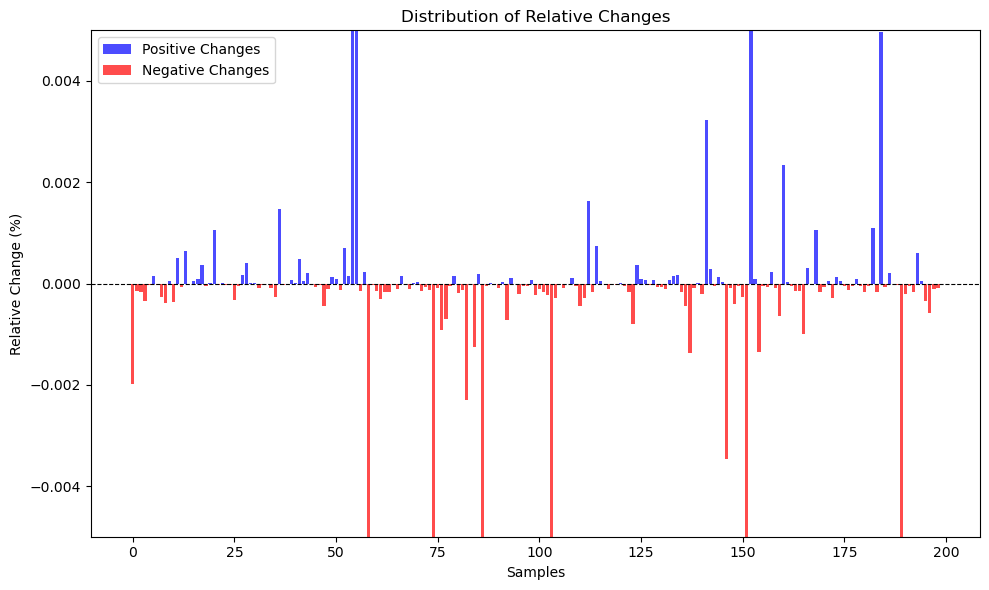

In [61]:
evaluate_explanations(ttc4900_results, ylim=(-0.005, 0.005))

### TR News

In [53]:
model_tr_news_output = create_model_output_function(model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, model_tr_news.bert.embeddings)

ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                tr_news_test, 
                                                lig_tr_news, 
                                                model_tr_news, tokenizer_tr_news, 
                                                "ig_and_scores_tr_news", 
                                                only_load=False)

top_tokens_tr_news = apply_thresholding(ig_values_tr_news, tokenizer_tr_news, threshold)

ig_values_tr_news_short, score_vis_tr_news_short = apply_ig(path_ig, 
                                                            top_tokens_tr_news, 
                                                            lig_tr_news,
                                                            model_tr_news, tokenizer_tr_news,
                                                            "ig_and_scores_tr_news_short", 
                                                            only_load=False)

tr_news_results = compare_probs(tr_news_test,
                                full_text_preds_tr_news,
                                top_tokens_tr_news,
                                1,
                                model_tr_news, tokenizer_tr_news,
                                pipeline_text_tr_news,
                                pipeline_parameters,
                                device, 
                                id2label_tr_news)

show(tr_news_results, lengthMenu=list(range(10, 200, 30)), dom="lti")

Loaded 'ig_and_scores_tr_news' file length: 199
Loaded 'ig_and_scores_tr_news_short' file length: 199


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [41]:
viz.visualize_text([score_vis_tr_news[101]])
viz.visualize_text([score_vis_tr_news_short[101]])
display()


Explanations Contribution Score (ECS)          :  0.985
Overall Relative Change (ORC) positive changes :  2.4457 %
Overall Relative Change (ORC) negative changes : -2.5325 %


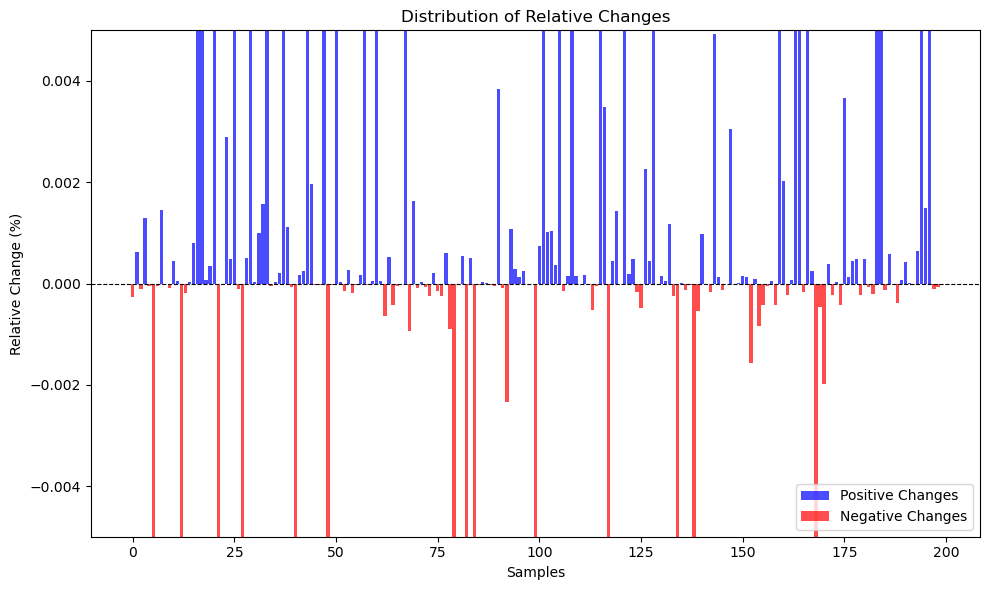

In [42]:
evaluate_explanations(tr_news_results, ylim=(-0.005, 0.005))

### Interpress

In [ ]:
model_interpress_output = create_model_output_function(model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, model_interpress.bert.embeddings)

ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                      interpress_test, 
                                                      lig_interpress, 
                                                      model_interpress, tokenizer_interpress, 
                                                      "ig_and_scores_interpress", 
                                                      only_load=False)

top_tokens_interpress = apply_thresholding(ig_values_interpress, tokenizer_interpress, threshold)

ig_values_interpress_short, score_vis_interpress_short = apply_ig(path_ig, 
                                                                  top_tokens_interpress, 
                                                                  lig_interpress,
                                                                  model_interpress, tokenizer_interpress,
                                                                  "ig_and_scores_interpress_short", 
                                                                  only_load=False)

interpress_results = compare_probs(interpress_test,
                                   full_text_preds_interpress,
                                   top_tokens_interpress,
                                   1,
                                   model_interpress, tokenizer_interpress,
                                   pipeline_text_interpress,
                                   pipeline_parameters,
                                   device, 
                                   id2label_interpress)

show(interpress_results, lengthMenu=list(range(10, 200, 30)), dom="lti")

In [ ]:
viz.visualize_text([score_vis_interpress[101]])
viz.visualize_text([score_vis_interpress_short[101]])
display()

In [ ]:
evaluate_explanations(interpress_results, ylim=(-0.005, 0.005))

### TC 32

In [ ]:
model_tc32_output = create_model_output_function(model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, model_tc32.bert.embeddings)

ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                          tc32_test, 
                                          lig_tc32, 
                                          model_tc32, tokenizer_tc32, 
                                          "ig_and_scores_tc32", 
                                          only_load=False)

top_tokens_tc32 = apply_thresholding(ig_values_tc32, tokenizer_tc32, threshold)

ig_values_tc32_short, score_vis_tc32_short = apply_ig(path_ig, 
                                                      top_tokens_tc32, 
                                                      lig_tc32,
                                                      model_tc32, tokenizer_tc32,
                                                      "ig_and_scores_tc32_short", 
                                                      only_load=False)

tc32_results = compare_probs(tc32_test,
                                   full_text_preds_tc32,
                                   top_tokens_tc32,
                                   1,
                                   model_tc32, tokenizer_tc32,
                                   pipeline_text_tc32,
                                   pipeline_parameters,
                                   device, 
                                   id2label_tc32)

show(tc32_results, lengthMenu=list(range(10, 200, 30)), dom="lti")

In [ ]:
viz.visualize_text([score_vis_tc32[101]])
viz.visualize_text([score_vis_tc32_short[101]])
display()

In [ ]:
evaluate_explanations(tc32_results, ylim=(-0.005, 0.005))